In [21]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [22]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [23]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.sql import func, desc
from flask import Flask, jsonify

In [24]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [25]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [26]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [27]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [28]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [29]:
# Find the most recent date in the data set.
session.query(func.max(Measurements.date)).scalar()

'2017-08-23'

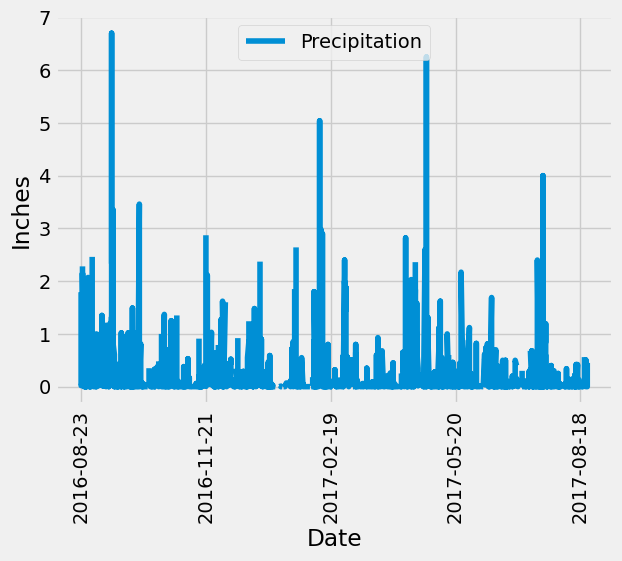

In [30]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date_query = session.query(func.max(Measurements.date)).scalar()
last_date = pd.to_datetime(last_date_query)

# Calculate the date one year from the last date in data set.
one_year_ago = last_date - pd.DateOffset(years=1)
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurements.date, Measurements.prcp).\
    filter(Measurements.date >= one_year_ago_str).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precip, columns=['date', 'prcp'])

# Sort the dataframe by date
precip_data = {date:prcp for date, prcp in precip}
df =df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(df['date'], df['prcp'])
plt.xlabel('Date')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=90))
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.legend(['Precipitation'],loc='upper center')
plt.show()

In [31]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['prcp'].describe()
summary_stats_df = pd.DataFrame(summary_stats)
summary_stats_df

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [32]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Stations).count()
total_stations

9

In [33]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurements.station, func.count().label('count')).group_by(Measurements.station).order_by(desc('count'))
most_active_stations.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [35]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = session.query(Measurements.station, func.count().label('count')).group_by(Measurements.station).order_by(func.count().desc()).first()[0]

query = session.query(
func.min(Measurements.tobs).label('lowest_temp'), \
func.max(Measurements.tobs).label('highest_temp'), \
func.avg(Measurements.tobs).label('avg_temp')).\
filter(Measurements.station == most_active_station_id)

result = query.first()

lowest_temp = result.lowest_temp
highest_temp = result.highest_temp
avg_temp = result.avg_temp

print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


<Axes: ylabel='Frequency'>

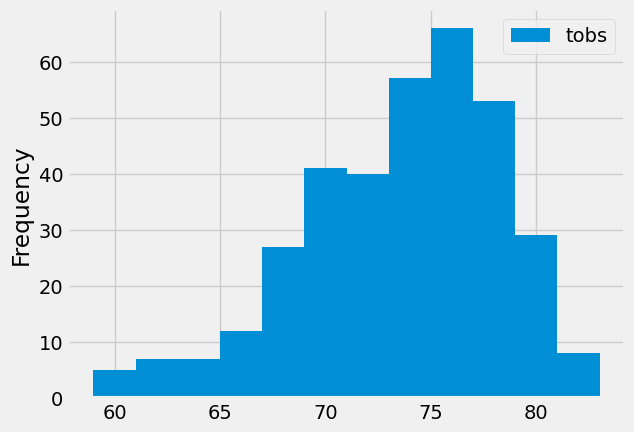

In [36]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurements.tobs).filter(Measurements.station == most_active_station_id).filter(Measurements.date >= one_year_ago_str).all()
results_df = pd.DataFrame(results, columns=['tobs'])
results_df.plot.hist(bins=12)

# Close Session

In [16]:
# Close Session
session.close()